# 01 - Adatfeltárás (Data Exploration)
Ebben a notebookban betöltjük a rendelkezésre álló CSV fájlokat, és vizualizáljuk az árfolyamokat, hogy ellenőrizzük az adatok minőségét.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import json

# Útvonal beállítása
DATA_DIR = "../data" if os.path.exists("../data") else "/app/data"
print(f"Adatok könyvtára: {DATA_DIR}")

# CSV fájlok keresése minden alkönyvtárban
# A glob '**/*.csv' rekurzívan keres, ha a recursive=True be van állítva
csv_files = glob.glob(os.path.join(DATA_DIR, "**", "*.csv"), recursive=True)

print(f"Összesen {len(csv_files)} CSV fájlt találtunk.")

# Opcionális: Lista kiírása (csak az első 5-öt, hogy ne szemetelje tele a kimenetet)
for f in csv_files[:5]:
    # A relatív utat írjuk ki a DATA_DIR-hez képest
    rel_path = os.path.relpath(f, DATA_DIR)
    print(f" - {rel_path}")
if len(csv_files) > 5:
    print(f" ... és további {len(csv_files)-5} db.")

Adatok könyvtára: ../data
Összesen 185 CSV fájlt találtunk.
 - AY1PC8\EURUSD_15min_003.csv
 - AY1PC8\EURUSD_1H_005.csv
 - AY1PC8\EURUSD_1min_001.csv
 - AY1PC8\EURUSD_30min_004.csv
 - AY1PC8\EURUSD_5min_002.csv
 ... és további 180 db.


--------------------------------------------------


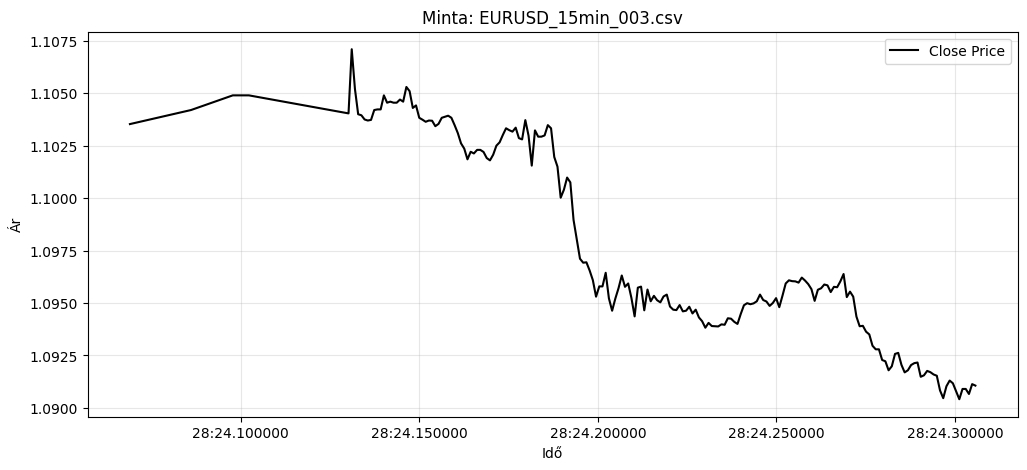

Fájl: ../data\AY1PC8\EURUSD_15min_003.csv
Méret: 3341 sor
--------------------------------------------------


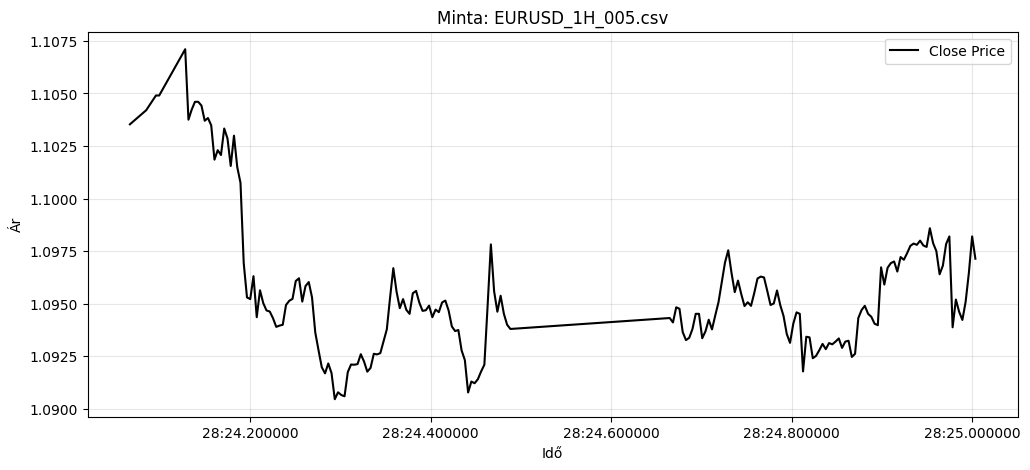

Fájl: ../data\AY1PC8\EURUSD_1H_005.csv
Méret: 840 sor
--------------------------------------------------


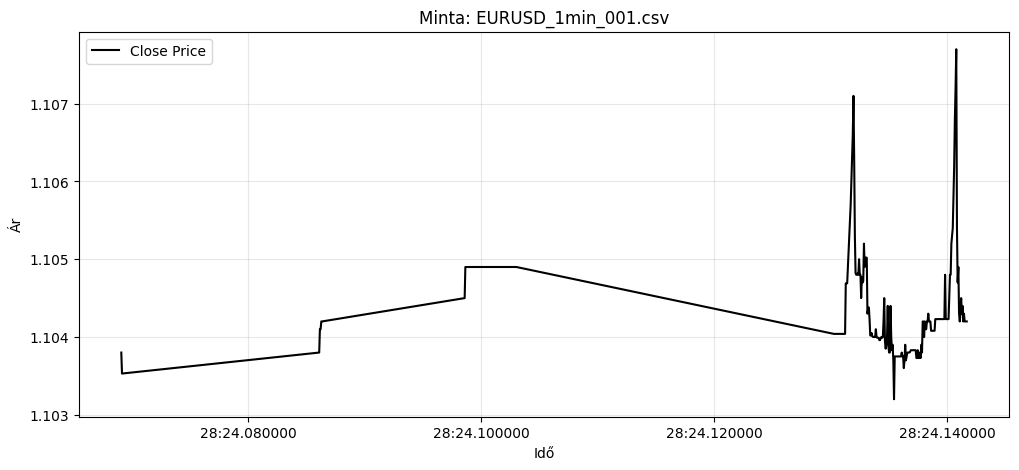

Fájl: ../data\AY1PC8\EURUSD_1min_001.csv
Méret: 50000 sor


In [5]:
def plot_sample(file_path):
    """Betölt egy CSV-t és kirajzolja az első 200 gyertyát."""
    try:
        df = pd.read_csv(file_path)
        # Oszlopnevek egységesítése
        df.columns = [c.capitalize() for c in df.columns]
        
        if 'Timestamp' in df.columns:
            df['Timestamp'] = pd.to_datetime(df['Timestamp'])
            df = df.set_index('Timestamp').sort_index()
        
        plt.figure(figsize=(12, 5))
        # Ellenőrzés, hogy van-e adat
        if len(df) > 0:
            cols_to_plot = 'Close' if 'Close' in df.columns else df.columns[0]
            plt.plot(df.index[:200], df[cols_to_plot][:200], label='Close Price', color='black')
            
        plt.title(f"Minta: {os.path.basename(file_path)}")
        plt.xlabel("Idő")
        plt.ylabel("Ár")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()
        print(f"Fájl: {file_path}")
        print(f"Méret: {len(df)} sor")
    except Exception as e:
        print(f"Hiba a {file_path} betöltésekor: {e}")

# Minta kirajzolása az első 3 talált fájlból
for f in csv_files[:3]:
    print("-" * 50)
    plot_sample(f)

--------------------------------------------------


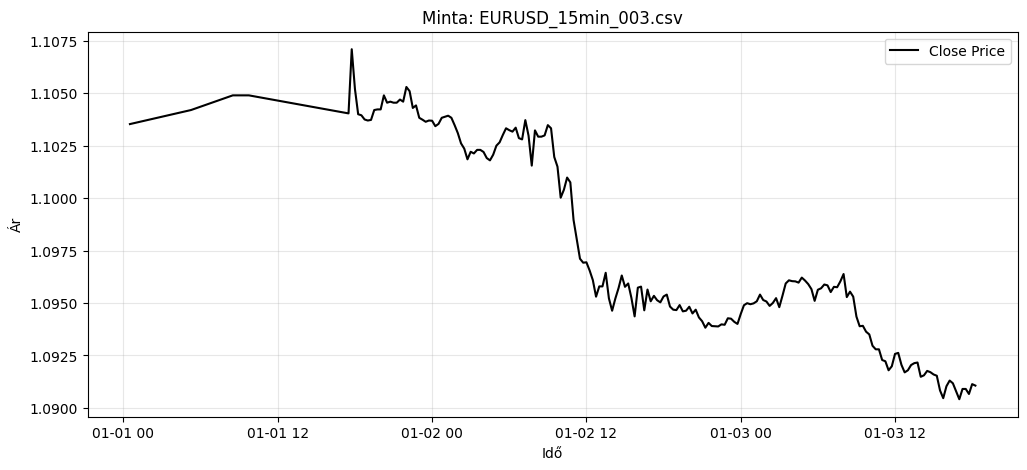

Fájl: ../data\AY1PC8\EURUSD_15min_003.csv
Méret: 3341 sor
--------------------------------------------------


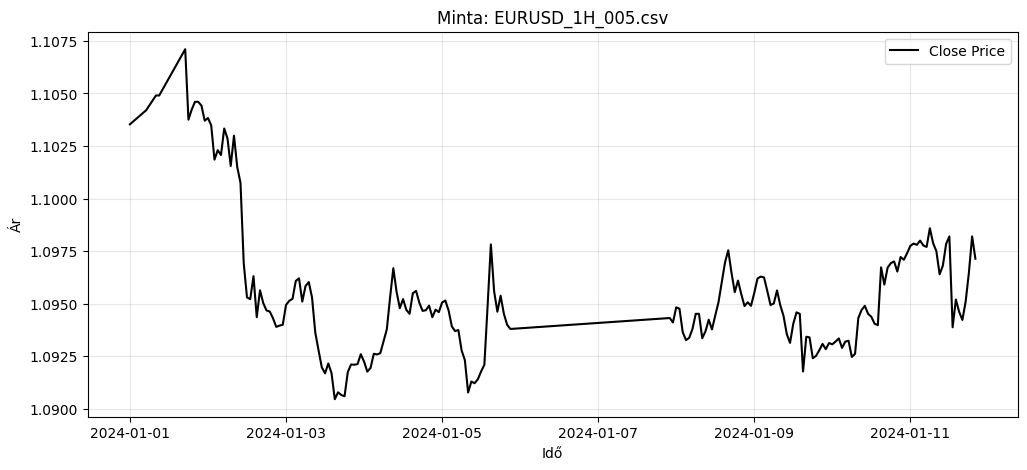

Fájl: ../data\AY1PC8\EURUSD_1H_005.csv
Méret: 840 sor
--------------------------------------------------


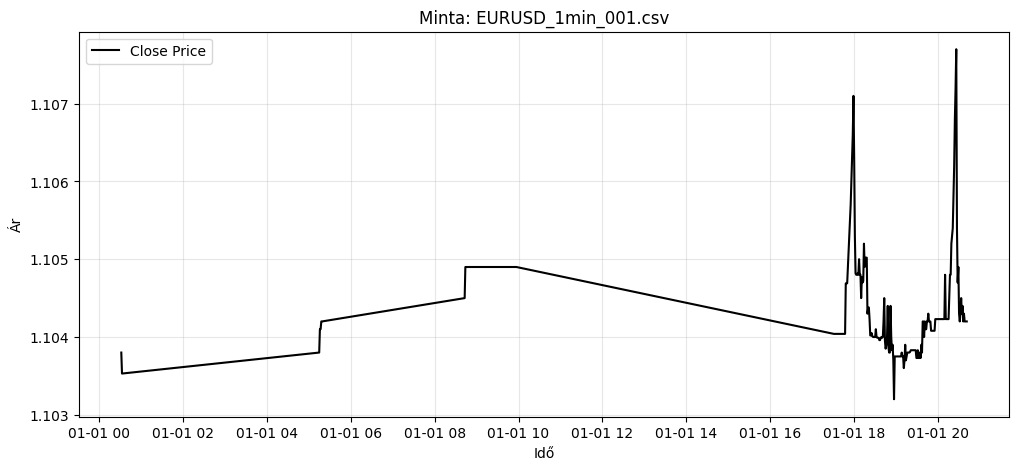

Fájl: ../data\AY1PC8\EURUSD_1min_001.csv
Méret: 50000 sor


In [6]:
def robust_parse_dates(df):
    """
    Javított dátumfelismerés DataFrame oszlopra.
    Kezeli a Unix timestamp-et (s/ms) és string dátumokat is.
    """
    col_map = {c.lower(): c for c in df.columns}
    ts_col = col_map.get('timestamp') or col_map.get('time') or col_map.get('date')
    
    if not ts_col:
        return df

    # Próbáljuk meg numerikussá alakítani
    temp_col = pd.to_numeric(df[ts_col], errors='coerce')
    
    # Ha a többség szám (Unix timestamp)
    if temp_col.notna().sum() > len(df) * 0.8:
        temp_col = temp_col.ffill().bfill()
        first_val = temp_col.iloc[0]
        
        # > 3e10 (kb 1971-es év másodpercben) -> valószínűleg ms
        if first_val > 3e10:
            df[ts_col] = pd.to_datetime(temp_col, unit='ms')
        else:
            df[ts_col] = pd.to_datetime(temp_col, unit='s')
    else:
        df[ts_col] = pd.to_datetime(df[ts_col], errors='coerce')

    df = df.set_index(ts_col).sort_index()
    return df

def plot_sample(file_path):
    """Betölt egy CSV-t és kirajzolja az első 200 gyertyát."""
    try:
        df = pd.read_csv(file_path)
        # Oszlopnevek egységesítése
        df.columns = [c.capitalize() for c in df.columns]
        
        # --- JAVÍTOTT RÉSZ ---
        df = robust_parse_dates(df)
        # ---------------------
        
        plt.figure(figsize=(12, 5))
        # Ellenőrzés, hogy van-e adat
        if len(df) > 0:
            cols_to_plot = 'Close' if 'Close' in df.columns else df.columns[0]
            plt.plot(df.index[:200], df[cols_to_plot][:200], label='Close Price', color='black')
            
        plt.title(f"Minta: {os.path.basename(file_path)}")
        plt.xlabel("Idő")
        plt.ylabel("Ár")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()
        print(f"Fájl: {file_path}")
        print(f"Méret: {len(df)} sor")
    except Exception as e:
        print(f"Hiba a {file_path} betöltésekor: {e}")

# Minta kirajzolása az első 3 talált fájlból
for f in csv_files[:3]:
    print("-" * 50)
    plot_sample(f)

Összesen 95 task feldolgozása a mintákhoz...


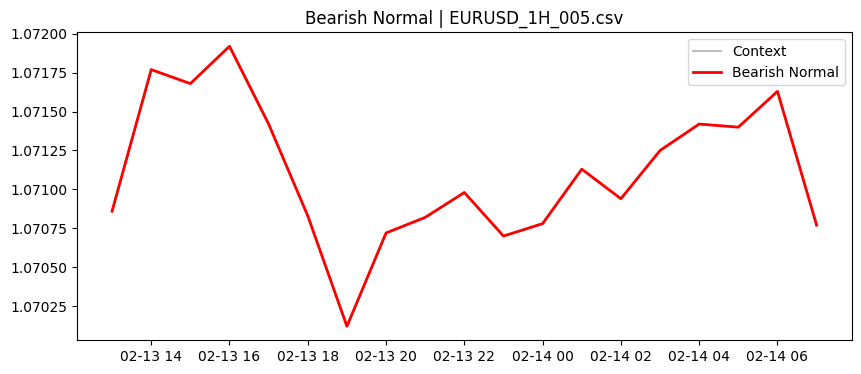

✅ Bearish Normal found.


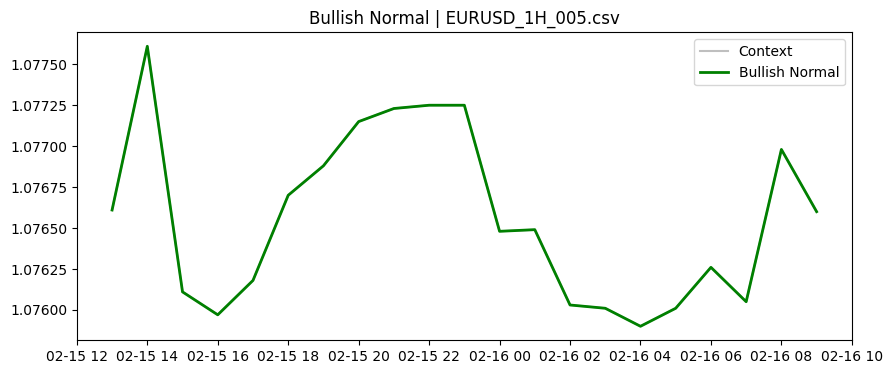

✅ Bullish Normal found.


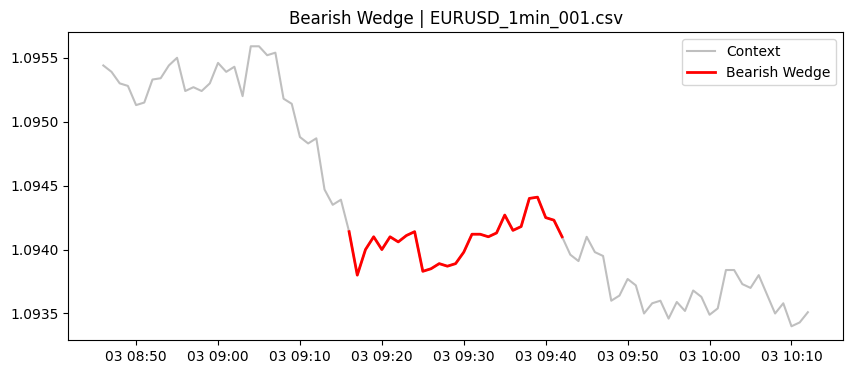

✅ Bearish Wedge found.


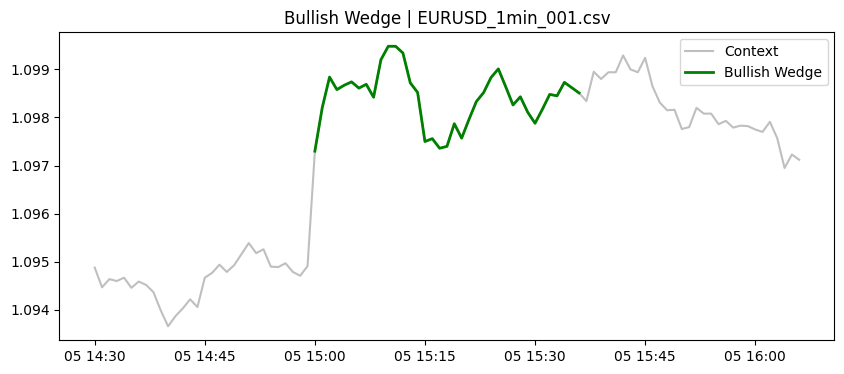

✅ Bullish Wedge found.


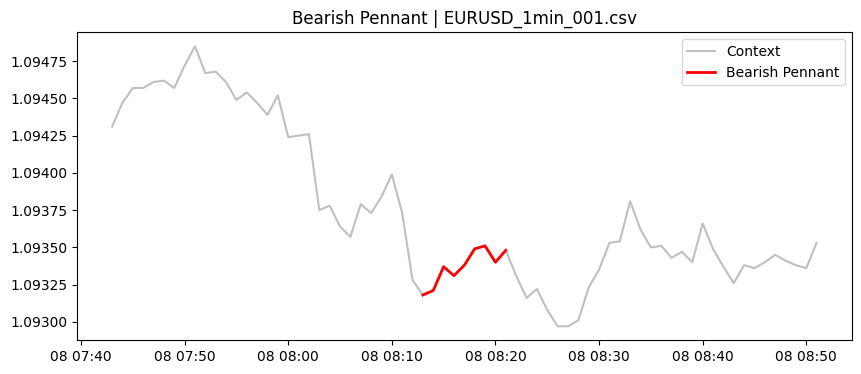

✅ Bearish Pennant found.


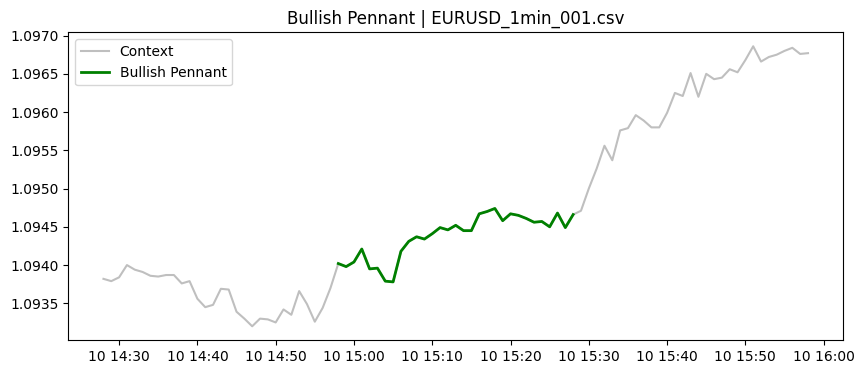

✅ Bullish Pennant found.


In [7]:
def parse_annotation_time(time_val):
    """
    Egyetlen JSON időérték biztonságos parse-olása.
    """
    if time_val is None:
        return None
    try:
        numeric_ts = float(time_val)
        if numeric_ts > 3e10: 
            return pd.to_datetime(numeric_ts, unit='ms')
        else:
            return pd.to_datetime(numeric_ts, unit='s')
    except (ValueError, TypeError):
        return pd.to_datetime(time_val)

def find_csv_path_recursive(filename, root_dir):
    """Megkeresi a fájlt a root_dir alatt bárhol."""
    matches = glob.glob(os.path.join(root_dir, "**", filename), recursive=True)
    if matches: return matches[0]
    
    simple_name = filename.split('-')[-1] if '-' in filename else filename
    all_csvs = glob.glob(os.path.join(root_dir, "**", "*.csv"), recursive=True)
    for f in all_csvs:
        if os.path.basename(f).endswith(simple_name) or simple_name in os.path.basename(f):
            return f
    return None

def visualize_all_patterns():
    # Labels.json fájlok keresése - itt is a javított logikával
    all_tasks = []
    
    # Mappák bejárása JSON fájlokért (függetlenül a nevüktől)
    for root, dirs, files in os.walk(DATA_DIR):
        for file in files:
            if file.endswith(".json"):
                full_path = os.path.join(root, file)
                try:
                    with open(full_path, 'r') as f:
                        tasks = json.load(f)
                        for t in tasks: t['_source_dir'] = root
                        all_tasks.extend(tasks)
                except Exception as e:
                    print(f"Hiba a {full_path} olvasásakor: {e}")

    targets = {
        "Bullish Normal": False, "Bullish Pennant": False, "Bullish Wedge": False,
        "Bearish Normal": False, "Bearish Pennant": False, "Bearish Wedge": False
    }
    
    print(f"Összesen {len(all_tasks)} task feldolgozása a mintákhoz...")

    for task in all_tasks:
        if all(targets.values()): break

        filename = task.get('file_upload')
        if not filename: continue
        
        csv_path = find_csv_path_recursive(filename, DATA_DIR)
        
        if not csv_path: continue
        
        df = None # Lazy load
        
        for ann in task.get('annotations', []):
            for res in ann.get('result', []):
                val = res.get('value', {})
                labels = val.get('timeserieslabels', [])
                if not labels: continue
                
                original_label = labels[0]
                
                direction = "Bullish" if "Bullish" in original_label else ("Bearish" if "Bearish" in original_label else None)
                shape = "Normal"
                if "Pennant" in original_label: shape = "Pennant"
                elif "Wedge" in original_label: shape = "Wedge"
                
                if not direction: continue
                target_key = f"{direction} {shape}"
                
                if target_key in targets and not targets[target_key]:
                    if df is None:
                        try:
                            df = pd.read_csv(csv_path)
                            df.columns = [c.capitalize() for c in df.columns]
                            
                            # --- JAVÍTOTT RÉSZ ---
                            df = robust_parse_dates(df)
                            # ---------------------
                        except: break

                    # --- JAVÍTOTT RÉSZ ---
                    start = parse_annotation_time(val.get('start'))
                    end = parse_annotation_time(val.get('end'))
                    # ---------------------
                    
                    if start is None or end is None: continue

                    margin = pd.Timedelta(minutes=30)
                    
                    mask = (df.index >= start - margin) & (df.index <= end + margin)
                    subset = df.loc[mask]
                    
                    if len(subset) > 0:
                        plt.figure(figsize=(10, 4))
                        plt.plot(subset.index, subset['Close'], color='gray', alpha=0.5, label='Context')
                        
                        pat_mask = (subset.index >= start) & (subset.index <= end)
                        plt.plot(subset.loc[pat_mask].index, subset.loc[pat_mask]['Close'], 
                                 color='green' if direction == "Bullish" else 'red', linewidth=2, label=target_key)
                        
                        plt.title(f"{target_key} | {os.path.basename(csv_path)}")
                        plt.legend()
                        plt.show()
                        targets[target_key] = True
                        print(f"✅ {target_key} found.")

visualize_all_patterns()